In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import plotly.express as px 
import scipy.stats as sst

import my_paths as mp

from src.metrics import get_flower_constancy_index

# Floral constancy
Calculated for different shapes of flowers. This figures anchors everything to a theoretical background.

Furthemore for the sake of organizing data for long term storage and future proof, makes a 
first attmept at a flower ontology to clasify the experiments done and to be done.


### Synthetic data
since I dont have yet some data, and I would like to starte designing my figures

ideally the input data has a very simple shape, a sequences of events that relate one of n bees, interacting with one of
m flowers

some extra metadata can be present, like the date of the data aquisition

aditionaly the m flowers are defined by some extra parameters like internal shape, direction, color, reward volumen and
reward concentration.
this second might become a table on its own, but for now it will be extra columns in the main table

finally I need to specify which camera is attached to each flower so I can relate bees, and events to video captures.



In [3]:
# todo think about the ontology of flowers
#  for example, what to do with flower reward

flower_df = pd.DataFrame([
    {'id_flower':0, 'color': 'blue', 'sinuosity': 'bend_1', 'direction': 'right'},
    {'id_flower':1, 'color': 'white', 'sinuosity': 'bend_1', 'direction': 'left'},
    {'id_flower':2, 'color': 'blue', 'sinuosity': 'zig_1', 'direction': 'right'},
    {'id_flower':3, 'color': 'white', 'sinuosity': 'zig_1', 'direction': 'left'}
])

print(flower_df.head())

   id_flower  color sinuosity direction
0          0   blue    bend_1     right
1          1  white    bend_1      left
2          2   blue     zig_1     right
3          3  white     zig_1      left


In [4]:
# Creates the synthetic data frame similar to what it might look 
# when acquiring results from experiments.

rng = np.random.default_rng(seed=42)
n_bees = 10
n_events = 1000 #if 100 breaks, check

visit_df = pd.DataFrame(
    {'bee': rng.choice(n_bees, n_events),
     'id_flower': rng.choice(
         flower_df.id_flower.unique().tolist(), n_events
     )}
)
for col in visit_df.columns:
    visit_df[col] = visit_df[col].astype("int")

print(visit_df.head())

   bee  id_flower
0    0          3
1    7          2
2    6          2
3    4          3
4    4          0


In [5]:
# merge relevant data about flowers
# care with how="left" to preserve the order of the visit_df

working_df = pd.merge(
    left = visit_df.reset_index(), right= flower_df,
    how='left', on = 'id_flower'
)
print(working_df.head())

   index  bee  id_flower  color sinuosity direction
0      0    0          3  white     zig_1      left
1      1    7          2   blue     zig_1     right
2      2    6          2   blue     zig_1     right
3      3    4          3  white     zig_1      left
4      4    4          0   blue    bend_1     right


# flower constancy
as stated in Waser 1986

firist define the transition frequency matrix between flowers, as if it was a markov chain


| flower | blue | white |
|--------|------|-------|
| Blue   | A    | B     |
| White  | C    | D     |


$ CONS = \frac{\sqrt{AD} - \sqrt{BC}}{\sqrt{AD} + \sqrt{BC}} $

Jacobson (), 

In [6]:
toplot = working_df.copy()
toplot = toplot.groupby(["bee","sinuosity"]).agg(
    flower_constancy=('color', get_flower_constancy_index),
).reset_index()
print(toplot.head())

   bee sinuosity  flower_constancy
0    0    bend_1         -0.127017
1    0     zig_1          0.223178
2    1    bend_1         -0.040000
3    1     zig_1         -0.218975
4    2    bend_1         -0.171573


RanksumsResult(statistic=-0.11338934190276817, pvalue=0.9097218891455553)
bend_1: WilcoxonResult(statistic=10.0, pvalue=0.083984375)
bend_1: Ttest_1sampResult(statistic=-1.934608272571914, pvalue=0.08504173579832949)
zig_1: WilcoxonResult(statistic=18.0, pvalue=0.375)
zig_1: Ttest_1sampResult(statistic=-1.0562954091359789, pvalue=0.3183614490914747)


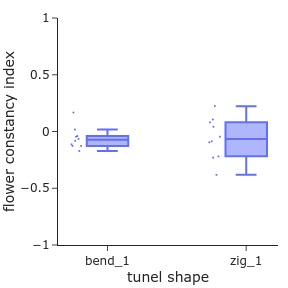

In [7]:
# statistical comparison beetween pairs of flowers
pair_diff_stat = sst.ranksums(
    x = toplot.query("sinuosity == 'bend_1'").flower_constancy,
    y = toplot.query("sinuosity == 'zig_1'").flower_constancy
)
print(pair_diff_stat)

# statistical conmparision between each flower and zero
for sinu in toplot.sinuosity.unique():
    fwr_stat = sst.wilcoxon(
        x=toplot.query(f"sinuosity == '{sinu}'").flower_constancy
    )
    print(f"{sinu}: {fwr_stat}")
    
    # perhaps I dont need non parametric?
    fwr_stat = sst.ttest_1samp(
        a=toplot.query(f"sinuosity == '{sinu}'").flower_constancy,
        popmean=0
    )
    print(f"{sinu}: {fwr_stat}")

##### plotting #####

fig = px.box(
    toplot, x='sinuosity', y='flower_constancy', points='all',
)

fig.update_traces(width=0.3,
                  marker_size=2,
                  line_width=2)

fig.update_layout(
    template="simple_white",
    width=96 * 3, height=96 * 3,
    margin=dict(l=40, r=10, t=10, b=20),
    xaxis=dict(title=dict(text='tunel shape', standoff=0)),
    yaxis=dict(range=[-1, 1],
               title=dict(text='flower constancy index', standoff=0)),
    violingap=0, violingroupgap=0, violinmode='overlay',
)

fig.show(renderer='jpeg', scale=1)
fig.write_image((mp.fig_path / "floral_constancy").with_suffix(".svg"))
